<a href="https://colab.research.google.com/github/mrezky-mr/ASPIRE2021/blob/main/Simple_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this model, I tried to simulate the cloud collapse without taking into account the stellar fields. This means that I'm only adding particles into the simulation.

**Question**: Do I right in this or should I add a star in the simulation in the first hand? I take this approach because I thought that we're trying to do particle-particle interaction first, rather than having a center of mass which will become the center of the collapse.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jul  2 00:42:22 2021

@author: mrezky
"""

#some initialization
import rebound
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

sim = rebound.Simulation()
sim.units = ('yr','au','kg')

#I'm running this code on my campus server, so I have to turn off the interactivity of mpl codes
plt.ioff()
mpl.use('Agg')

In [ ]:
#integrator options
sim.integrator = "ias15"
sim.dt = 0.025*2.*np.pi # we're working in units where 1 year = 2*pi
sim.testparticle_type = 1
sim.ri_ias15.min_dt = 1e-6 # ensure that close encounters do not stall the integration 

I've tried Mercurius (from [Rein's example](https://rebound.readthedocs.io/en/latest/ipython_examples/PrimordialEarth.html)) and IAS15 (the one that I have experience with it). It seems that the energy offset from Mercurius is a bit high than IAS15 (which just in order of $10^{-2}$).

For the *sim.testparticle_type = 1*, I use it because we want to see all particles interacting with each other.

The *im.ri_ias15.min_dt = 1e-6* is coming from the example.

**Question**:
1.   How we choose what kind of integrator that we'll use in the future?
2.   What was the reasoning behind the *im.ri_ias15.min_dt = 1e-6* line? How would close encounters stall the integration?



For the next part, I am activating the collision effect as *direct* collision, which will always resulted in *merge* of involved particles. In the end, I will present each remaining particle's mass and radius.

In [ ]:
#collision and boundary options
sim.collision = "direct"
sim.collision_resolve = "merge"
sim.collision_resolve_keep_sorted = 1
sim.track_energy_offset = 1

Establishing some random variable generator. Straight from the [Rein's example](https://rebound.readthedocs.io/en/latest/ipython_examples/PrimordialEarth.html).

In [ ]:
def rand_powerlaw(slope, min_v, max_v):
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))

def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum

def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

For this part below, I used some assumption from Rein et al. (2010) paper, with radius
> $$R = H = 0.01 \ AU$$ 

(which also the Hill radius of the Earth), surface solid density of the disk

> $$\rho_{s} = 8900 \ kg \ m^{-3}$$

(from the MMSN parameters, with $\rho_s = 890 \ g \ cm^{-2}$ and solid to gas ratio $\rho_s/\rho_g = 0.01$). This means that the total mass of the disk is $436310597.1 \ kg$.

Using 10000 as the amount of particles involved in the simulation and the equation

> $$a_{num} = \frac{0.014}{\sqrt{N_{num}}} \ AU$$

I found that the particle's radius would be $1.4 \ \cdot \ 10^{-4} \ AU$. (**Question**: Is this right? Is this the intended result from using scaled particles?)

In [ ]:
N_pl = 10000                        # Number of planetesimals
Mtot_disk = 436310597.1             # Total mass of planetesimal disk
m_pl = Mtot_disk / float(N_pl)      # Mass of each planetesimal
r_pl = 1.4e-4                       # Radius of each planetesimal

#adding the first particle in the center of the disk, intended to be a primary for all particle.
sim.add(m=m_pl,r=r_pl)

In [ ]:
#setting the random distribution of particle's position, using the random variable generator established before
np.random.seed(50) # by setting a seed we will reproduce the same simulation every time
while sim.N < (N_pl + sim.N_active):
    a = rand_powerlaw(0, 0, 0.01)
    e = rand_rayleigh(0.01)
    inc = rand_rayleigh(0.005)
    f = rand_uniform(-np.pi, np.pi) 
    p = rebound.Particle(simulation=sim,primary=sim.particles[0],m=m_pl, r=r_pl, a=a, e=e, inc=inc, Omega=0, omega=0, f=f)
    sim.add(p)

In [ ]:
sim.move_to_com()
E0 = sim.calculate_energy()

In [ ]:
# plotting the particles in the initial condition
coords = np.zeros((2,sim.N))
for i in range(sim.N):
    coords[0][i], coords[1][i] = sim.particles[i].x, sim.particles[i].y

fig1, ax1 = plt.subplots()
ax1.axis('equal')
ax1.scatter(coords[0],coords[1], s=2)
ax1.scatter(sim.particles[0].x,sim.particles[0].y, s=2)
plt.savefig("initial.png")
plt.close(fig1)

This is the initial state of the simulation that I run by myself.

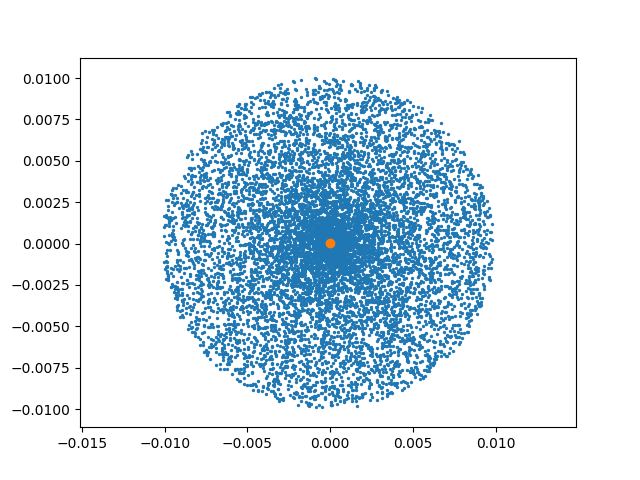

In [ ]:
#integrate all particles
times = np.linspace(0.,2000.,2000) #integrate it for 318 orbits.
encounterN = np.zeros(len(times))
totalN = np.zeros(len(times))
errors = np.zeros(len(times))
for i,t in enumerate(times):
    sim.integrate(t)
    totalN[i] = sim.N
    errors[i] = abs((sim.calculate_energy() - E0)/E0)
    if t % 100 < 1: #make an updated plot once every 100 timestamps.
        coords = np.zeros((2,sim.N))
        for i in range(sim.N):
            coords[0][i], coords[1][i] = sim.particles[i].x, sim.particles[i].y
        fign, ax = plt.subplots()
        ax.axis('equal')
        ax.scatter(coords[0],coords[1], s=2)
        ax.scatter(sim.particles[0].x,sim.particles[0].y, s=2)
        plt.savefig("t_{a}.png".format(a=int(t)))
        plt.close(fign)
    print(t)

**Question**: I'm still not sure about this simulation, because of the active/semi-active status of the particles that had to be set before the integration. I use the first particle in (0,0,0) position as the primary. All particles here had been assigned a mass, tho, so I don't think the later particles will be treated by the code as test particles. What do you think? Do you think this code assume all particles to be active particles or test particles?

In [ ]:
#plotting the final status of the system, adopted from Rein's example.
fig2 = plt.figure(figsize=(10,7))
axa = plt.subplot(211)
plt.yscale("log")
plt.plot(times/(2.*np.pi), errors)
axa.set_ylabel("Relative energy error")

axb = plt.subplot(212)
axb.set_ylabel("Lost/merged particles")
axb.set_xlabel("Time [orbits]")
plt.plot(times/(2.*np.pi), -(totalN-N_pl-2))
plt.savefig("stats.png")
plt.close(fig2)

This is the result of the code above. As I said before, the IAS15 integrator generate a relative energy error in the order of $10^{-2}$. Honestly, the second plot doesn't really help, so I tried to extract the mass and radius of the remaining particles.

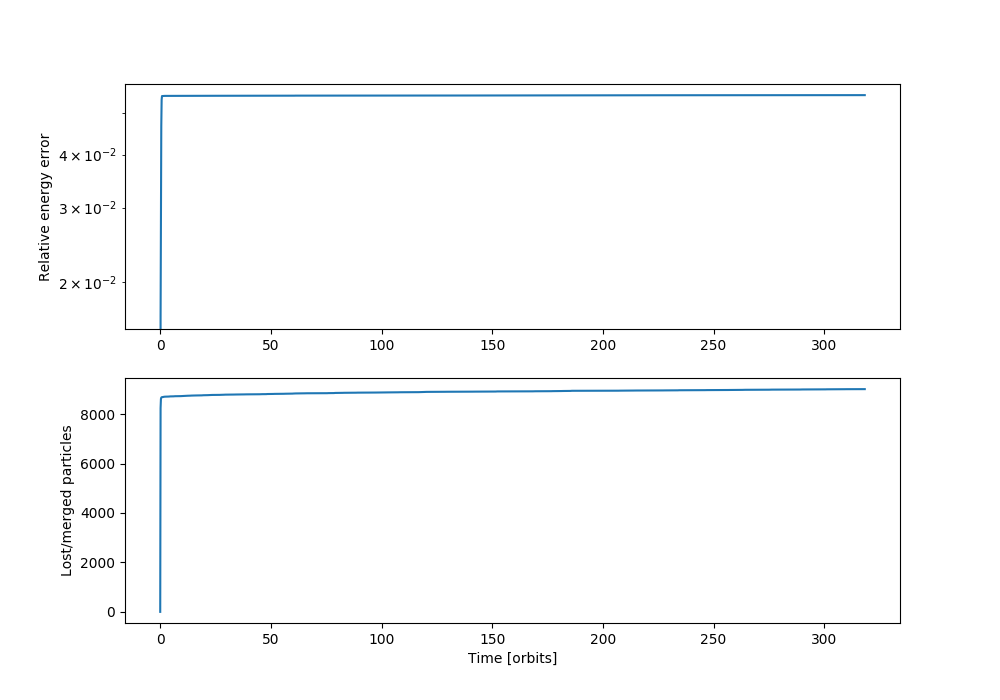

In [ ]:
p_mass = []
p_rad = []

coords = np.zeros((2,sim.N))
for i in range(sim.N):
    coords[0][i], coords[1][i] = sim.particles[i].x, sim.particles[i].y
    p_mass.append(sim.particles[i].m)
    p_rad.append(sim.particles[i].r)

#extracting the data of radius and mass of the remaining particles    
dat = np.vstack((p_mass, p_rad))
np.savetxt("final_pdata.txt", dat)

#plotting the final position of the particles.    
fig3, ax = plt.subplots()
ax.axis('equal')
ax.scatter(coords[0],coords[1], s=2)
ax.scatter(sim.particles[0].x,sim.particles[0].y, s=2)
plt.savefig("final.png")
plt.close(fig3)

This is the plot. For the rest of the plots (the one for every 100 timestamps) and the radius-mass txt, you can found it on [my drive here](https://drive.google.com/drive/folders/1xoCq1UumR4f1Z3cdqaep-TV7h6W1l5Ll?usp=sharing). If you've seen the txt, you might find many particles have their radius and mass grew. Some of it even grew from $10^4 \ kg$ to $10^7 \ kg$.

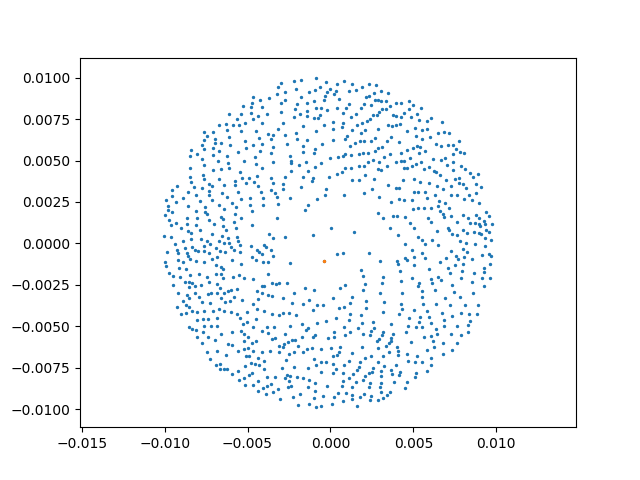

So what do you think, is this the same thing that you had on your mind or do I need to revise the code or even the understanding behind it?